In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

In [2]:
%run '/Users/sabanejad/Projects/demand-response/functions.py'

In [157]:
tariffs = pd.read_parquet('tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

lows_2012 = lows - np.timedelta64(365, 'D')
normals_2012 = normals - np.timedelta64(365, 'D')
highs_2012 = highs - np.timedelta64(365, 'D')

In [159]:
total_acorn = pd.read_parquet('total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [14]:
total_usage_2013 = pd.read_parquet('total_usage_2013.gzip')
total_usage_2014 = pd.read_parquet('total_usage_2014.gzip')

In [15]:
total_usage_2013_sliced = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() <= '2013-02-27')]
total_usage_2014 = total_usage_2014.loc[(total_usage_2014['date_time'].dt.normalize() <= '2014-02-27')]

In [16]:
df_2013_treatment_sliced, df_2013_control_sliced = split_t_c(total_usage_2013_sliced)
df_2014_treatment, df_2014_control = split_t_c(total_usage_2014)

In [93]:
a_2013_, b_2013_, a_2014_, b_2014_ = get_matrices(df_2013_treatment_sliced, 
                                                  df_2013_control_sliced, df_2014_treatment, df_2014_control, 0.01)

before anything (2784, 4406) (2784, 1111) (2784, 4065) (2784, 1043)
after cleaning (2784, 4281) (2784, 1091) (2784, 3445) (2784, 896)
after house intersection (2784, 3413) (2784, 879) (2784, 3413) (2784, 879)


In [94]:
n = 0

a_2013 = impute(a_2013_.iloc[n:, :].values, np.nanmedian, 1)
b_2013 = impute(b_2013_.iloc[n:, :].values, np.nanmedian, 1)
a_2014 = impute(a_2014_.iloc[n:, :].values, np.nanmedian, 1)
b_2014 = impute(b_2014_.iloc[n:, :].values, np.nanmedian, 1)

In [98]:
a_2014_inv = np.linalg.pinv(a_2014)
X = a_2014_inv @ b_2014
b_2013_tilde = a_2013 @ X

In [ ]:
b_2013_tilde_ = pd.DataFrame(b_2013_tilde, columns=b_2013_.iloc[n:, :].columns, index=b_2013_.iloc[n:, :].index)

In [135]:
delta = (b_2013 - b_2013_tilde) / b_2013_tilde

In [139]:
delta = (b_2013.mean(axis=1)-b_2013_tilde.mean(axis=1)) / b_2013_tilde.mean(axis=1)*100

In [142]:
delta = (b_2013_tilde.mean(axis=1)-b_2013.mean(axis=1)) / b_2013.mean(axis=1)*100

In [137]:
delta.flatten()

array([ 0.06723459, -0.93525902, -0.87861789, ..., -0.84944986,
       -0.66127186, -0.98075503])

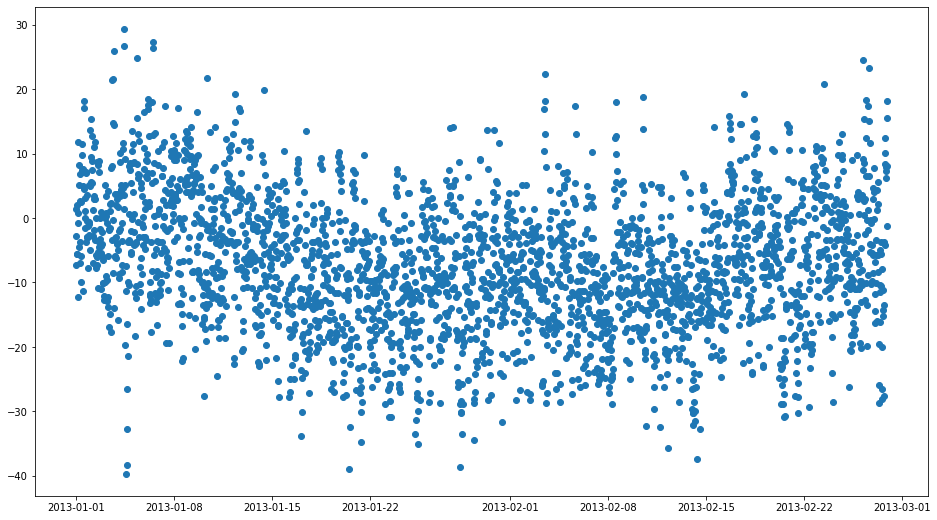

In [143]:
plt.figure(figsize=(16, 9))
plt.scatter(b_2013_.index, delta);

In [209]:
total_usage_2014['hour'] = total_usage_2014['date_time'].dt.hour

In [263]:
# time_of_day_2014 = total_usage_2014.groupby([total_usage_2014['hour'], total_usage_2014['treated']])['KWH/hh'].mean()
time_of_day_2014 = total_usage_2014.groupby([total_usage_2014['hour']])['KWH/hh'].mean()

In [376]:
len(a_2014_.mean(axis=1).values)

2784

In [471]:
def func(x, a, b, c, d, e, f):
    return [a * math.sin(e * x_i+ f) + b * math.sin(c * x_i) + d for x_i in x]

In [3]:
xdata = np.arange(0, 500)
ydata = a_2014_.mean(axis=1).values[:500]*10
yguess = func(xdata, 1.5, 0.2, 20, 2.5, 0.5, 10)

NameError: name 'a_2014_' is not defined

In [4]:
plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
plt.plot(xdata, yguess, 'r', label='guess data')
# plt.plot(xdata, func(xdata, *popt), 'r')
# , label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt)
plt.title('Consumption vs Temperature Fit')
plt.xlabel('time')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [303]:
from scipy.optimize import curve_fit

In [497]:
popt, _ = curve_fit(func, xdata, ydata, p0=(1.5, 0.2, 20, 2.5, 0.5, 10), bounds=[(0.01, 1, 0.08, -math.inf, -math.inf, -math.inf), (0.9, math.inf, 2, math.inf, math.inf, math.inf)])
popt

ValueError: `x0` is infeasible.

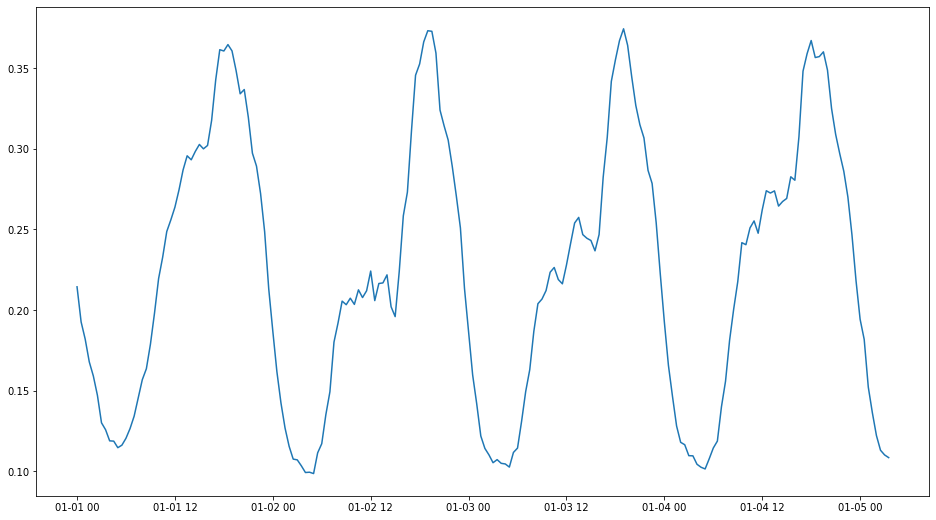

In [479]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
# plt.plot(b_2013_tilde.mean(axis=1)[:500])
# plt.plot(b_2013.mean(axis=1)[:500])
plt.plot(b_2014_.mean(axis=1)[:200]);

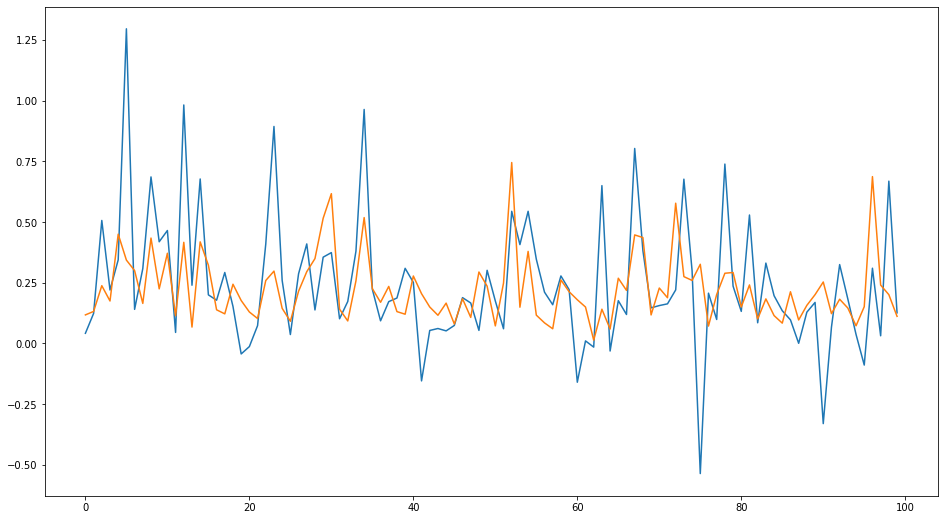

In [117]:
plt.figure(figsize=(16, 9))
plt.plot(b_2013_tilde.mean(axis=0)[:100])
plt.plot(b_2013.mean(axis=0)[:100])

In [498]:
def get_subset(mat, time, socio):
    return mat.loc[mat.index.isin(time), mat.columns.isin(socio)]

In [196]:
highs_affluent_delta = get_subset(highs, affluent)
lows_affluent_delta = get_subset(lows, affluent)

highs_comfortable_delta = get_subset(highs, comfortable)
lows_comfortable_delta = get_subset(lows, comfortable)

highs_adversity_delta = get_subset(highs, adversity)
lows_adversity_delta = get_subset(lows, adversity)

In [488]:
highs_affluent_delta.values.flatten()

array([ -177.80796468, -1480.07059122,   -26.44881328, ...,
         -69.70965394,  -161.20892852,   -32.27495502])

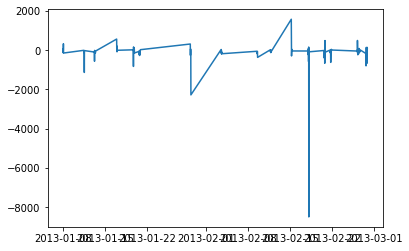

In [495]:
b_2013_.loc[b_2013_.index.isin(time), b_2013_.columns.isin(socio)]

In [494]:
highs_affluent_delta

house_id,MAC000005,MAC000015,MAC000017,MAC000048,MAC000052,MAC000064,MAC000075,MAC000076,MAC000082,MAC000109,...,MAC005395,MAC005413,MAC005445,MAC005470,MAC005488,MAC005489,MAC005507,MAC005515,MAC005541,MAC005550
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-07 23:00:00,-177.807965,-1480.070591,-26.448813,-50.730832,-88.909737,-15.171902,-91.478697,-59.859634,-34.611735,83.445620,...,-42.101885,-39.380842,-192.539691,-47.510116,-21.955720,-167.810130,-32.103580,-75.093634,-17.485480,157.790213
2013-01-07 23:30:00,-866.563579,-13.861489,-88.598932,-42.226237,-86.548868,-51.156269,-76.267886,-50.919357,-80.667301,1255.026796,...,-79.880578,-13.457720,-99.695761,-82.861390,-75.623528,-119.027457,-62.921304,-68.139307,-185.851712,202.142140
2013-01-08 00:00:00,174.993362,39.970815,-126.531975,-63.103772,-73.526206,-67.405472,-62.303098,-32.879907,-70.848230,-34.823217,...,-83.505768,-32.102836,-94.826344,-212.831650,-87.935337,-119.374389,-131.816106,-71.504275,-60.642835,-0.162613
2013-01-08 00:30:00,-69.962676,-68.880481,-128.747640,-27.841591,-127.873355,-44.220366,-76.844180,-72.424507,142.857173,216.975435,...,-83.526397,64.216745,-100.000000,-234.211913,-93.307221,-124.520317,-23.614551,-71.566181,-49.882633,2676.624622
2013-01-08 01:00:00,-47.853749,-83.378901,-124.312138,-275.799169,-90.023528,-60.251722,-752.428974,-70.387794,-86.521612,-76.141121,...,-92.756195,1251.565489,-93.423439,-134.290336,-76.398894,0.921061,-974.885242,-78.670934,11.596766,-49.599358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-27 20:30:00,-64.007950,-86.151390,-88.038683,-81.599630,-87.946223,-161.121133,-41.868058,78.295532,-124.669837,-91.035243,...,139.908371,-62.353362,-83.813236,-125.948925,-74.962686,-13.140825,-117.470837,-1311.852422,-126.448361,-70.812435
2013-02-27 21:00:00,-75.586254,-77.622614,-90.013730,-83.335146,-86.701291,-121.333252,68.846754,-64.806647,-104.961662,-92.213425,...,210.639765,-50.516862,-96.102278,-116.013236,-70.898386,-58.396919,-161.000207,-146.239928,-149.503754,-67.191484
2013-02-27 21:30:00,-115.899408,13.922277,-70.377686,-55.666020,-93.765717,-76.075589,-84.282327,18.225894,-106.125051,-84.551946,...,-2858.592460,-79.596598,-81.894343,-140.445223,-68.967376,-64.159444,-507.795277,-150.430415,-181.086076,-44.601139
